# Privacy

### Data Import

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
from mbi import FactoredInference

In [23]:
from mbi import Dataset, Domain, FactoredInference
from scipy.sparse import identity
from numpy.random import normal

url = './data/adult.data'

names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
         'marital-status', 'occupation', 'relationship', 'race',
         'gender', 'capital-gain', 'capital-loss', 'hours-per-week',
         'native-country', 'income']

adult = pd.read_csv(url, sep=',\s+', header=None, names=names, na_values='?', engine='python', skipinitialspace=True)

adult.dropna(inplace=True)

queries = ["age", "education-num"]
measurement_log = []
for c in queries :
    M_c = adult[c].values
    y_c = M_c + normal(loc =0 , scale = 50 , size = M_c.shape)
    measurement_log.append((identity(M_c.size) , y_c , 50 , c ))
engine = FactoredInference(Domain(adult[queries[0]], adult[queries[0]]))
model = engine.estimate(measurement_log)
synth = model.synthetic_data()

AssertionError: ('age',) not contained in domain

## Privacy Model

#### We want to satisfy $\epsilon$-differencial privacy for the count query based on the age

For Example: Knowing Bob is a 45, the presence of Bob in the dataset should not be information tha is recoverable from the queries we execute.

To ensure this, we want to verify that given:
* D dataset without Bob
* D' dataset with Bob
* q query function
* c a result for the count query

> $P(q(D) = c) \le e^\epsilon * P(q(D') = c)$ and $P(q(D') = c) \le e^\epsilon * P(q(D) = c)$

## Implementation

### Utils definition

In [16]:
## Config

EPSILON = 0.1

In [17]:
def laplace(ecart_type):
    r = random.random() - 0.5
    sgn = 1 if r >= 0 else -1
    return ecart_type * sgn * np.log(1 - 2 * abs(r))

def disturb_result(res, epsilon, sensitivity):
    return res + laplace(sensitivity/epsilon)

### Query function

In [20]:
def query_count(lower_bound, upper_bound):
    _hidden_result = adult[(adult["age"] <= upper_bound) & (adult["age"] >= lower_bound)].shape[0]
    result = disturb_result(_hidden_result, EPSILON, 1)
    return round(result)

### Graphing of results

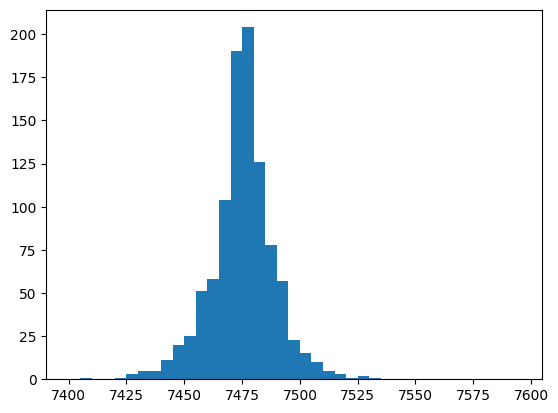

In [104]:
query_results = [query_count(40, 50) for _ in range(1000)]

plt.hist(query_results, bins = range(7400, 7600, 5));